## Classification
1. Feature processing: scaling, selection
2. Classify

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp drive/MyDrive/UNI/IPOTERI/data . -r

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample

plt.style.use('ggplot')
%matplotlib inline

In [4]:
# utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates[:1]:
            print("Model rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# undersample the positive class of a dataset, make it more balanced
def undersample(X, y, percentage=0.5):
    X_pos, y_pos = X[y==1], y[y==1]
    X_neg, y_neg = X[y==0], y[y==0]
    undersample = sample(list(range(len(X_pos))), round(len(X_pos)*percentage))
    X_u = np.concatenate([X_pos[undersample, :], X_neg], axis=0)
    y_u = np.concatenate([y_pos[undersample], y_neg], axis=0)

    print("\t Positive \t Negative")
    print(f"Before:\t {len(y_pos)} \t\t {len(y_neg)}")
    print(f"After:\t {len(y_pos[undersample])} \t\t {len(y_neg)}")
    return X_u, y_u

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Counter({1.0: 538, 0.0: 442})
Counter({0.0: 442})
Counter({1.0: 480, 0.0: 442})


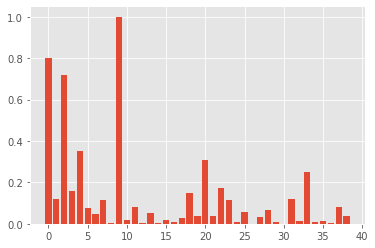

In [5]:
# 2. feature processing
import scipy.stats as stats
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, fbeta_score, make_scorer, accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.utils.class_weight import compute_class_weight

years = 7
df_train = pd.read_csv(f"data/{years}y/train.csv", index_col=0).to_numpy()
df_valid = pd.read_csv(f"data/{years}y/valid.csv", index_col=0).to_numpy()
X_train, y_train = df_train[:, :-1], df_train[:, -1]
X_valid, y_valid = df_valid[:, :-1], df_valid[:, -1]

numerical_features = list(range(8))+list(range(20, 24))
preprocess_minmax = ColumnTransformer(
                            transformers = [('minmax', MinMaxScaler(), numerical_features)], 
                            remainder="passthrough"
                            )
preprocess_std = ColumnTransformer(
                            transformers = [('stand', StandardScaler(), numerical_features)], 
                            remainder="passthrough"
                            )
preprocess_std_all = StandardScaler()


# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, chi2
selector = SelectKBest(chi2, k=15)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(range(df_train.shape[-1]-1), scores)


# undersampling methods
# CC method can allow SVM, RF to have 0 FP
from collections import Counter
from imblearn.under_sampling import OneSidedSelection, EditedNearestNeighbours, ClusterCentroids
X_train_OSS, y_train_OSS = OneSidedSelection(n_neighbors=550, n_seeds_S=550).fit_resample(X_train, y_train)
X_train_ENN, y_train_ENN = EditedNearestNeighbours(n_neighbors=30).fit_resample(X_train, y_train)

print(Counter(y_train_OSS))
print(Counter(y_train_ENN))
print(Counter(y_train))

# X_train, y_train = X_train_OSS, y_train_OSS
# X_train, y_train = undersample(X_train, y_train, percentage=0.15)

In [6]:
# # save undersampled dataset
# names = pd.read_csv(f"data/{years}y/train.csv", index_col=0).columns
# tmp = np.concatenate((X_train, np.expand_dims(y_train, 1)), axis=1)
# tmp = pd.DataFrame(tmp, columns=names)
# tmp.to_csv(f"drive/MyDrive/UNI/IPOTERI/data/{years}y/train_OSS.csv")
path = f"drive/MyDrive/UNI/IPOTERI/data/{years}y/"

In [7]:
# # custom metrics
# def custom(y_true, y_pred):
#     tp = ((y_true==1) & (y_pred==1)).sum()
#     tn = ((y_true==0) & (y_pred==0)).sum()
#     fp = ((y_true==0) & (y_pred==1)).sum()
#     fn = ((y_true==1) & (y_pred==0)).sum()
#     # return fp / (tn + tp)
#     # return fp
#     if tp <= 100:
#         return 100
#     else: 
#         return fp / (fp + tn)

# score = make_scorer(custom, greater_is_better=False)

# # f2 if FN are more costly, f05 if FP are more costly
# f1_negative = make_scorer(f1_score, pos_label=0)
# f2_negative = make_scorer(fbeta_score, beta=2, pos_label=0)
# f05_negative = make_scorer(fbeta_score, beta=0.5, pos_label=0)

              precision    recall  f1-score   support

         0.0      0.276     0.755     0.404       110
         1.0      0.960     0.751     0.843       874

    accuracy                          0.751       984
   macro avg      0.618     0.753     0.623       984
weighted avg      0.884     0.751     0.794       984

auc macro 0.823


['drive/MyDrive/UNI/IPOTERI/data/7y/logreg.joblib']

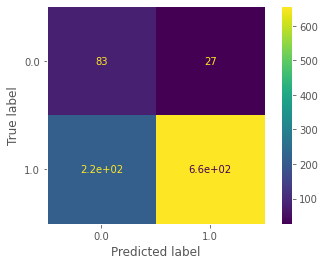

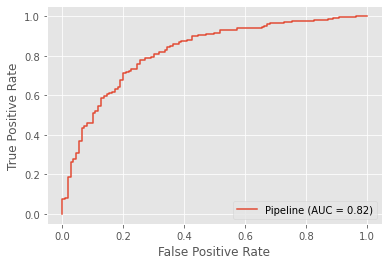

In [22]:
# 3. classify
# FP = network says survive=T but data says survive=F
# FN = network says survive=F but data says survive=T
# the goal is to minimize the FP, we don't want the model to "hide the sick patients"
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    # ('preprocess', preprocess_std), 
                    ('model', LogisticRegression(solver="lbfgs", class_weight="balanced"))
                ])

pipe.fit(X_train, y_train)
y = pipe.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(pipe, X_valid, y_valid, normalize=None)
plt.grid(False)

metrics.plot_roc_curve(pipe, X_valid, y_valid)

# import math
# w = logreg.coef_[0]
# feature_importance = pd.DataFrame(df_feat.columns[:-1], columns=["features"])
# feature_importance["importance"] = pow(math.e, w)
# feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
# feature_importance

# save and load
# dump(pipe["model"], path+"logreg.joblib")
# test = load(path+"logreg.joblib")

In [26]:
from sklearn.svm import SVC

hyperparams = {
    'model__C': stats.randint(1, 30),
    'model__kernel': ['rbf'],
    'model__degree': stats.randint(20, 80),
    'model__max_iter': stats.randint(500, 1500)
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    # ('preprocess', preprocess_std), 
                    ('preprocess', preprocess_std_all), 
                    ('model', SVC(class_weight="balanced", probability=True))
                ])

svc_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring='f1_macro',
                            # scoring=f1_negative,
                            # scoring=score,
                            # scoring=f05_negative,
                            scoring="accuracy",
                            n_iter=5000,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = svc_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, svc_rand.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(svc_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(svc_rand.cv_results_, n_top=3)

# save and load
# dump(svc_rand.best_estimator_["model"], path+"svc.joblib")
# test = load(path+"svc.joblib")

Fitting 2 folds for each of 5000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

              precision    recall  f1-score   support

         0.0      0.283     0.773     0.415       110
         1.0      0.963     0.754     0.846       874

    accuracy                          0.756       984
   macro avg      0.623     0.763     0.630       984
weighted avg      0.887     0.756     0.798       984



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1436).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


NotFittedError: ignored

Fitting 2 folds for each of 5000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 1320 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3720 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 5220 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 6920 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 8820 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 11.7min finished


              precision    recall  f1-score   support

         0.0      0.274     0.764     0.403       110
         1.0      0.962     0.745     0.839       874

    accuracy                          0.747       984
   macro avg      0.618     0.754     0.621       984
weighted avg      0.885     0.747     0.791       984

0.7542438111087997
Model rank: 1
Mean validation score: 0.783 (std: 0.004)
Parameters: {'model__criterion': 'gini', 'model__max_depth': 16, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 4, 'model__n_estimators': 54}

Model rank: 2
Mean validation score: 0.783 (std: 0.007)
Parameters: {'model__criterion': 'gini', 'model__max_depth': 6, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 54}

Model rank: 3
Mean validation score: 0.782 (std: 0.005)
Parameters: {'model__criterion': 'gini', 'model__max_depth': 19, 'model__max_features': 'log2', 'model__min_samples_l

['drive/MyDrive/UNI/IPOTERI/data/7y/rf.joblib']

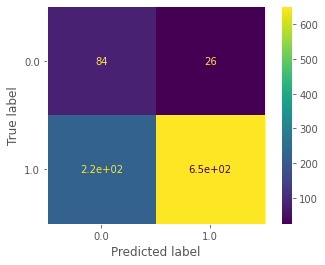

In [80]:
from sklearn.ensemble import RandomForestClassifier

hyperparams = {
    'model__n_estimators': stats.randint(30, 60),
    'model__criterion': ('gini', 'entropy'),
    'model__max_depth': stats.randint(1, 20),
    'model__min_samples_split': stats.randint(2, 10),
    'model__min_samples_leaf': stats.randint(1, 5),
    'model__max_features': ('sqrt', 'log2'),
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    ('model', RandomForestClassifier(class_weight="balanced"))
                ])

rf_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            scoring="accuracy",
                            # scoring='precision',
                            # scoring=f1_macro_negative,
                            # scoring="f1_macro",
                            # scoring=score,
                            n_iter=5000,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = rf_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, rf_rand.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(rf_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(rf_rand.cv_results_, n_top=3)

# feature importance use permutation importance
# importance = rf_rand.best_estimator_["model"].feature_importances_
# plt.bar(list(range(len(importance))), importance)

# save and load
# dump(rf_rand.best_estimator_["model"], path+"rf.joblib")
# test = load(path+"rf.joblib")

Fitting 2 folds for each of 5000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4964 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 7164 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 9764 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  4.9min finished


              precision    recall  f1-score   support

         0.0      0.305     0.664     0.418       110
         1.0      0.950     0.810     0.875       874

    accuracy                          0.794       984
   macro avg      0.628     0.737     0.646       984
weighted avg      0.878     0.794     0.824       984

0.7368525067609735
Model rank: 1
Mean validation score: 0.740 (std: 0.017)
Parameters: {'model__algorithm': 'kd_tree', 'model__n_neighbors': 18, 'model__weights': 'uniform'}



['drive/MyDrive/UNI/IPOTERI/data/7y/knn.joblib']

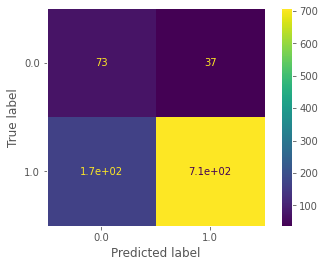

In [81]:
from sklearn.neighbors import KNeighborsClassifier

hyperparams = {
    'model__n_neighbors': stats.randint(2, 20),
    'model__weights': ('uniform', 'distance'),
    'model__algorithm': ('ball_tree', 'kd_tree', 'brute')
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    ('model', KNeighborsClassifier())
                ])

knn_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring="f1_macro",
                            # scoring=f1_macro_negative,
                            scoring="accuracy",
                            # scoring=score,
                            n_iter=5000,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = knn_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(knn_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(knn_rand.cv_results_, n_top=3)

# save and load
# dump(knn_rand.best_estimator_["model"], path+"knn.joblib")
# test = load(path+"knn.joblib")

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 26.9min finished


              precision    recall  f1-score   support

         0.0      0.256     0.718     0.377       110
         1.0      0.954     0.737     0.832       874

    accuracy                          0.735       984
   macro avg      0.605     0.728     0.604       984
weighted avg      0.876     0.735     0.781       984

0.7275119617224881
Model rank: 1
Mean validation score: 0.771 (std: 0.014)
Parameters: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.174535952523493, 'model__loss': 'exponential', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 66}

Model rank: 2
Mean validation score: 0.769 (std: 0.016)
Parameters: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.20172046594103415, 'model__loss': 'exponential', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 131}

Model rank: 3
Mean validation score: 0.768 (std: 0.004)
Parameters: {'m

['drive/MyDrive/UNI/IPOTERI/data/7y/gb.joblib']

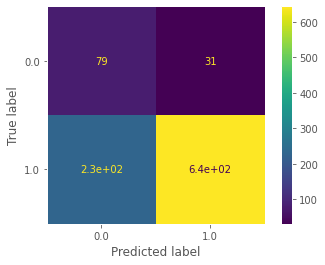

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

hyperparams = {
    'model__loss': ('deviance', 'exponential'),
    'model__learning_rate': stats.uniform(0.05, 0.2),
    'model__n_estimators': stats.randint(50, 150),
    'model__criterion': ('friedman_mse', 'mse', 'mae'),
    'model__min_samples_split': stats.randint(2, 4),
    'model__min_samples_leaf': stats.randint(1, 2),
    'model__max_depth': stats.randint(3, 6),
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    ('model', GradientBoostingClassifier())
                ])

gb_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring="f1_macro",
                            # scoring=f1_macro_negative,
                            scoring="accuracy",
                            # scoring=score,
                            n_iter=1000,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = gb_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(gb_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(gb_rand.cv_results_)

# save and load
# dump(gb_rand.best_estimator_["model"], path+"gb.joblib")
# test = load(path+"gb.joblib")

              precision    recall  f1-score   support

         0.0      0.281     0.755     0.410       110
         1.0      0.961     0.757     0.847       874

    accuracy                          0.757       984
   macro avg      0.621     0.756     0.628       984
weighted avg      0.885     0.757     0.798       984

auc macro 0.834
Model rank: 1
Mean validation score: 0.784 (std: 0.018)
Parameters: {'model__activation': 'relu', 'model__alpha': 0.11160853629584411, 'model__hidden_layer_sizes': 96, 'model__learning_rate_init': 0.0042854387588564915, 'model__max_iter': 108, 'model__solver': 'sgd'}

Model rank: 2
Mean validation score: 0.780 (std: 0.010)
Parameters: {'model__activation': 'logistic', 'model__alpha': 0.08543699986906839, 'model__hidden_layer_sizes': 96, 'model__learning_rate_init': 0.0056915262890046055, 'model__max_iter': 178, 'model__solver': 'adam'}

Model rank: 3
Mean validation score: 0.779 (std: 0.013)
Parameters: {'model__activation': 'relu', 'model__alpha': 

['drive/MyDrive/UNI/IPOTERI/data/7y/nn.joblib']

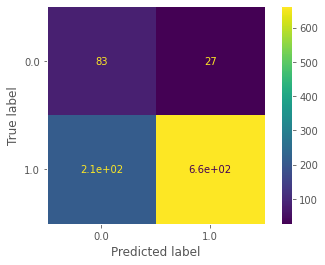

In [56]:
from sklearn.neural_network import MLPClassifier
from random import random

hyperparams = {
    'model__hidden_layer_sizes': stats.randint.rvs(10, 100, size=round(random()*2)+1),
    'model__activation': ('logistic', 'tanh', 'relu'),
    'model__solver': ('lbfgs', 'sgd', 'adam'),
    'model__learning_rate_init': stats.uniform(0.001, 0.01),
    'model__alpha': stats.uniform(),
    'model__max_iter': stats.randint(25, 300),
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    ('model', MLPClassifier())
                ])

nn_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring='f1_macro',
                            scoring
                             ='accuracy',
                            n_iter=500,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = nn_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, nn_rand.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(nn_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(nn_rand.cv_results_)

# save and load
# dump(nn_rand.best_estimator_["model"], path+"nn.joblib")
# test = load(path+"nn.joblib")